In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_date = dt.date(2017, 8, 1)
end_date = start_date + dt.timedelta(days=6)
trip_data = calc_temps(start_date, end_date)
trip_df = pd.DataFrame(trip_data, columns=["TMIN","TAVG","TMAX"])
trip_df

,TMIN,TAVG,TMAX
0,72.0,79.25,83.0


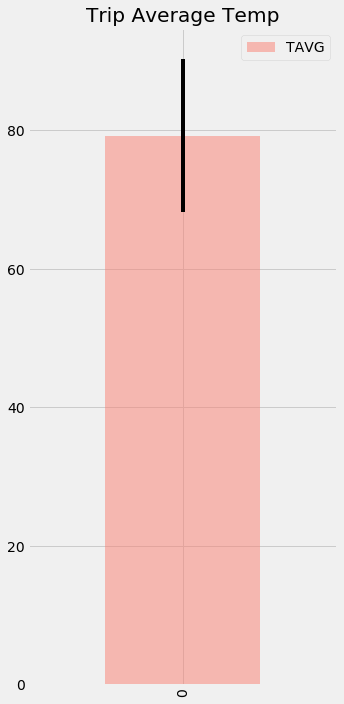

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_df.plot.bar(y="TAVG", yerr=(trip_df["TMAX"]-trip_df["TMIN"]), title="Trip Average Temp", alpha=0.5, figsize =(5,10), color='salmon')
plt.tight_layout()
plt.autolayout : True
plt.savefig("Trip Average Temperatures | August 1, 2017 - August 7, 2017")

plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = dt.date(2016, 8, 1)
rain_data = session.query(Station.station, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation)\
    .filter(Measurement.station == Station.station)\
    .filter(func.strftime("%Y-%m-%d", Measurement.date)>= start_date)\
    .group_by(Station.station)\
    .order_by(func.sum(Measurement.prcp).desc()).all()

rain_df = pd.DataFrame(rain_data, columns = ['Station', 'Latitude', 'Longitude','Elevation', 'Total Precipitation (in)'])

rain_df.head()

,Station,Latitude,Longitude,Elevation,Total Precipitation (in)
0,USC00516128,161.76,21.33310,-157.80250,152.4
1,USC00519281,80.06,21.45167,-157.84889,32.9
2,USC00513117,54.39,21.42340,-157.80150,14.6
3,USC00519523,40.14,21.33556,-157.71139,19.5
4,USC00514830,34.50,21.52130,-157.83740,7.0


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates # Strip off the year and save a list of strings in the format %m-%d
dates = ["08-01", "08-02","08-03","08-04", "08-05","08-06","08-07"]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
for date in dates:
    day = {}
    day['Date'] = f'2017-{date}'
    normal = daily_normals(date)
    day['Min'] = normal[0][0]
    day['Avg']=round(normal[0][1])
    day['Max']= normal[0][2]
    normals.append(day)
    
normals

[{'Date': '2017-08-01', 'Min': 67.0, 'Avg': 76, 'Max': 83.0},
 {'Date': '2017-08-02', 'Min': 68.0, 'Avg': 76, 'Max': 84.0},
 {'Date': '2017-08-03', 'Min': 70.0, 'Avg': 77, 'Max': 85.0},
 {'Date': '2017-08-04', 'Min': 69.0, 'Avg': 77, 'Max': 84.0},
 {'Date': '2017-08-05', 'Min': 69.0, 'Avg': 76, 'Max': 82.0},
 {'Date': '2017-08-06', 'Min': 67.0, 'Avg': 76, 'Max': 83.0},
 {'Date': '2017-08-07', 'Min': 71.0, 'Avg': 77, 'Max': 83.0}]

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates = pd.DataFrame(normals)
trip_dates.set_index('Date', inplace=True)
trip_dates

,Min,Avg,Max
Date,,,
2017-08-01,67.0,76,83.0
2017-08-02,68.0,76,84.0
2017-08-03,70.0,77,85.0
2017-08-04,69.0,77,84.0
2017-08-05,69.0,76,82.0
2017-08-06,67.0,76,83.0
2017-08-07,71.0,77,83.0


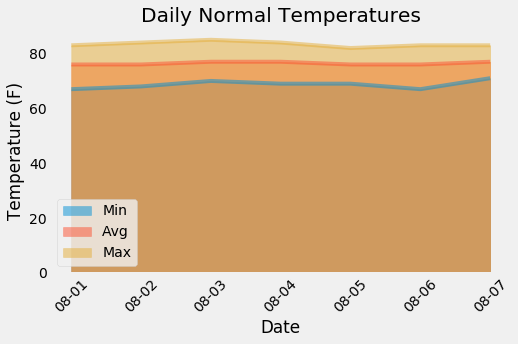

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax=plt.subplots(figsize = (8,5))
trip_dates.plot.area(ax = ax, stacked = False)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (F)')
ax.set_title('Daily Normal Temperatures')
temps = [f'2017-{date}' for date in dates]
ax.set_xticks(np.arange(len(temps)))
ax.set_xticklabels(dates, rotation = 45)
plt.grid()
plt.gcf().subplots_adjust(bottom=0.2)
plt.gcf().subplots_adjust(left=0.15)
plt.savefig("Trip Daily Temperatures | August 1, 2017 - August 7, 2017")
plt.show()

## Close Session

In [17]:
session.close()